In [17]:
%matplotlib inline
import numpy as np
import matplotlib as ma
import matplotlib.pyplot as plt
import torch
import random
from tqdm import tqdm

In [2]:
seed = 42

### 1.生成数据集

设 $\mathrm{w} = [2,-3.4]^\top, b = 4.2, \mathrm{X} \in \mathbb{R}^{1000\times 2}$
$$\mathrm{y} = \mathrm{Xw} + b + \epsilon$$

In [50]:
def synthetic_data(w, b, nums):
    X = torch.normal(0, 1, (nums,len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.view(-1)

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [51]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([0.4036, 1.8540]) 
label: tensor(-1.3114)


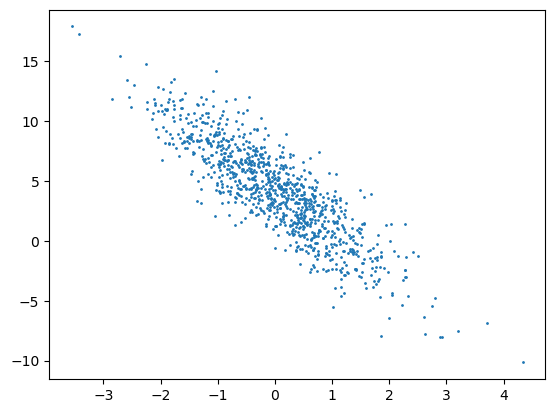

In [52]:
plt.scatter(features[:,1].detach().numpy(), labels.detach().numpy(), 1)

### 2. 读取数据集

每次只访问一些数据，优于直接加载全部数据

In [53]:
def data_iter(batch_size, features, labels):
    nums_examples = len(features)
    indics = list(range(nums_examples))
    random.shuffle(indics)
    for i in range(0, nums_examples, batch_size):
        batch_indics = torch.tensor(
            indics[i: min(i + batch_size, nums_examples)])
        yield features[batch_indics], labels[batch_indics]

In [54]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.2209, -0.9452],
        [ 0.6989,  0.3759],
        [ 0.5594,  1.0789],
        [-0.3988, -1.0976],
        [ 0.6800, -0.0827],
        [ 0.5324,  0.1876],
        [-1.1538,  2.9276],
        [-0.3595, -1.4755],
        [ 0.6261,  0.3905],
        [ 2.5675,  1.4942]]) 
 tensor([ 4.9750,  4.3222,  1.6708,  7.1295,  5.8147,  4.6408, -8.0635,  8.4930,
         4.1265,  4.2616])


### 3. 初始化模型参数

In [55]:
# w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
# b = torch.zeros(1, requires_grad=True)

w = torch.zeros(size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 4. 定义模型

In [56]:
def LinearModel(X, w, b):
    return torch.matmul(X, w) + b

### 5. 定义损失函数

In [57]:
def square_loss(y_hat, y):
    return (y.reshape(y_hat.shape) - y_hat) ** 2 / 2

### 6. 定义优化算法

In [58]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size #计算图的梯度已经在前向过程计算好了
            param.grad.zero_()

### 7. 训练

In [59]:
lr = 0.03
num_epochs = 3

for epoch in tqdm(range(num_epochs)):
    for X, y in data_iter(batch_size, features, labels):
        loss = square_loss(LinearModel(X, w, b), y)
        loss.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_loss = square_loss(LinearModel(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_loss.mean()):f}')

100%|██████████| 3/3 [00:00<00:00, 37.23it/s]

epoch 1, loss 0.040458
epoch 2, loss 0.000150
epoch 3, loss 0.000048


In [60]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-1.1778e-04, -4.4346e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0002], grad_fn=<RsubBackward1>)
